### Урок 7. Классификация с помощью KNN. Кластеризация K-means

1. К алгоритму kNN, реализованному на уроке, реализуйте добавление весов соседей по любому из показанных на уроке принципов.
2. Напишите функцию по подсчёту метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и постройте график её зависимости от k (взять от 1 до 10) для выборки данных из этого урока.

### Подготовительная часть

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Создан отдельный класс для реализации алгоритма knn

In [67]:
class KNN:
    """Класс для классификации методом ближайших соседей."""

    AVAILABLE_WEIGHTS = (None, 'index', 'dist')

    def __init__(self, *, k:int=5, weight:str=None, q:float=0.5):
        """
        Конструктор
        :param k: Количество соседей
        :param weight: Тип определения веса
            - None: без учета весов
            - index: Взвешивание в зависимости от номера соседа
            - dist: Взвешивание относительно расстояния
        :param q: Произвольное число для весов
        """
        self._k = k
        self._q = q
        self._weight = weight
        self._X = None
        self._y = None
        self._classes = None

        assert self._weight in self.AVAILABLE_WEIGHTS
        assert 0 < self._q < 1

    def fit(self, X, y):
        """
        Обучение модели.
        :param X: Фичи
        :param y: Целевое значение
        :return:
        """
        self._X = X
        self._y = y
        self._classes = set(y)

    def predict(self, X):
        """
        Получения классов для входных значений
        :param X:
        :return:
        """
        return [self._point_predict(point) for point in X]

    def _point_predict(self, point):
        """
        Получение класса для точки
        :param point:
        :return:
        """
        neighbors = self._get_neighbors(point)
        counter = {n[0]:0 for n in neighbors}
        if len(counter) == 1:
            # Если все соседи одного класса нет смысла
            return list(counter.keys())[0]
        i = 1
        for cl, dist in neighbors:
            counter[cl] += self._apply_weight(dist, i)
            i += 1
        return max(counter.items(), key=lambda x: x[1])[0]

    def _apply_weight(self, dist, idx):
        """
        Применяем взвешенное голосование
        :param dist: Расстояние
        :param idx: Номер соседа
        :return:
        """
        if self._weight == 'index':
            return self._q**idx
        if self._weight == 'dist':
            return self._q**dist
        return dist

    def _get_neighbors(self, point):
        """
        Получание K ближайших соседей
        :param point:
        :return:
        """
        distances = self._distances(point)
        distances.sort(key=lambda e: e[1])
        return distances[:self._k]

    def _distances(self, point) -> list:
        """
        Расчёт расстояний до каждой точки
        :param point:
        :return:
        """
        return [(self._y[i], self._e_metric(self._X[i], point)) for i in range(len(self._X))]

    def _e_metric(self,p1, p2) -> float:
        """
        Расчёт Евклидовой метрики
        :param p1: Точка 1
        :param p2: Точка 2
        :return: Расстояние между точками
        """
        distance = 0
        for i in range(len(p1)):
            distance += (p1[i] - p2[i]) ** 2
        return np.sqrt(distance)

    @staticmethod
    def accuracy(y_pred, y_test):
        return sum(y_pred == y_test) / len(y_test)


In [17]:
def get_graph(X_train, y_train, k, weight=None):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    model = KNN(k=k, weight=weight)
    model.fit(X_train,y_train)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_light)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"k: {k}.\n Метод весов: {weight}")
    plt.show()

In [6]:
def weight_humanize(w_value):
    if w_value == 'dist':
        return 'взвешенное относительно расстояния'
    elif w_value == 'index':
        return 'взвешенное относительно номера соседа'
    return 'невзвешенное'

### Практическая часть

##### К алгоритму kNN, реализованному на уроке, реализуйте добавление весов соседей по любому из показанных на уроке принципов.

In [38]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

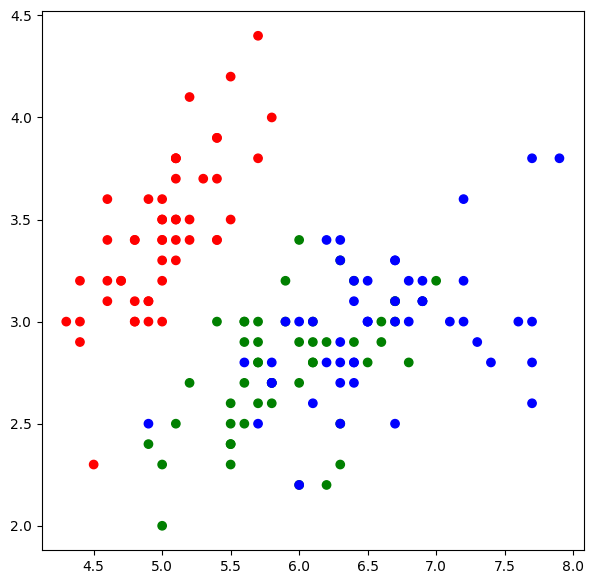

In [39]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [14]:
for w in [None, 'index', 'dist']:
    model = KNN(k=10, weight=w)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Точность KNN(10) при головосвании {weight_humanize(w)}: {model.accuracy(y_pred, y_test)}')

Точность KNN(10) при головосвании невзвешенное: 0.8333333333333334
Точность KNN(10) при головосвании взвешенное относительно номера соседа: 0.7
Точность KNN(10) при головосвании взвешенное относительно расстояния: 0.8666666666666667


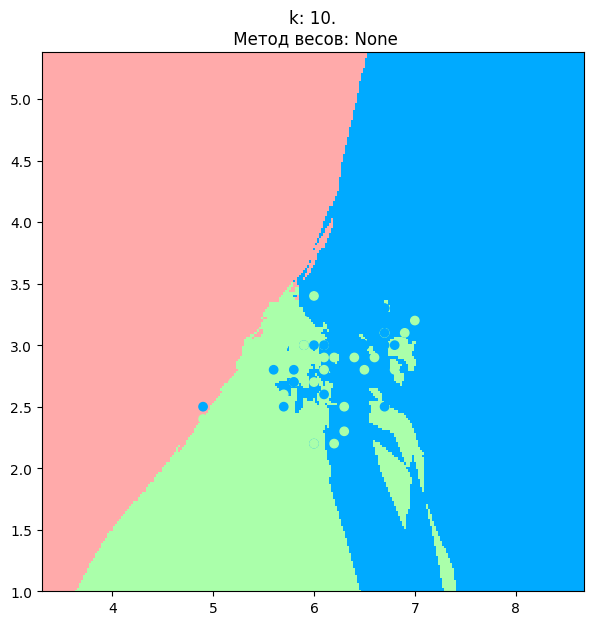

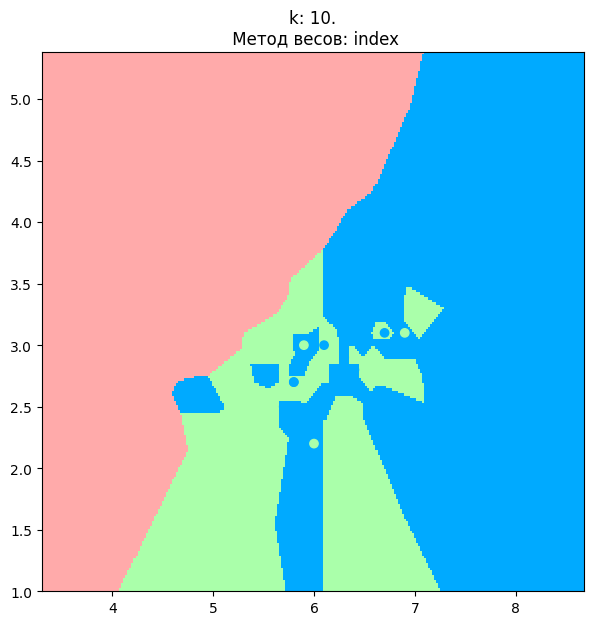

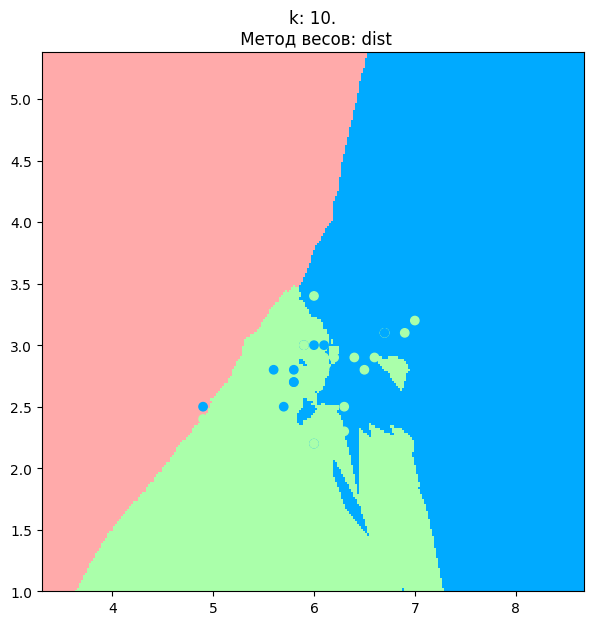

In [18]:
for weights in [None,'index','dist']:
    get_graph(X_train, y_train, 10, weights)

##### Напишите функцию по подсчёту метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и постройте график её зависимости от k (взять от 1 до 10) для выборки данных из этого урока.

In [68]:
weights = (None, 'index', 'dist')
k_variants = range(1,11)
results = { w: [] for w in weights }

for w in weights:
    for k in k_variants:
        model = KNN(k=k, weight=w,q=0.3)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)

        results[w].append(model.accuracy(y_pred, y_test))

<function matplotlib.pyplot.show(close=None, block=None)>

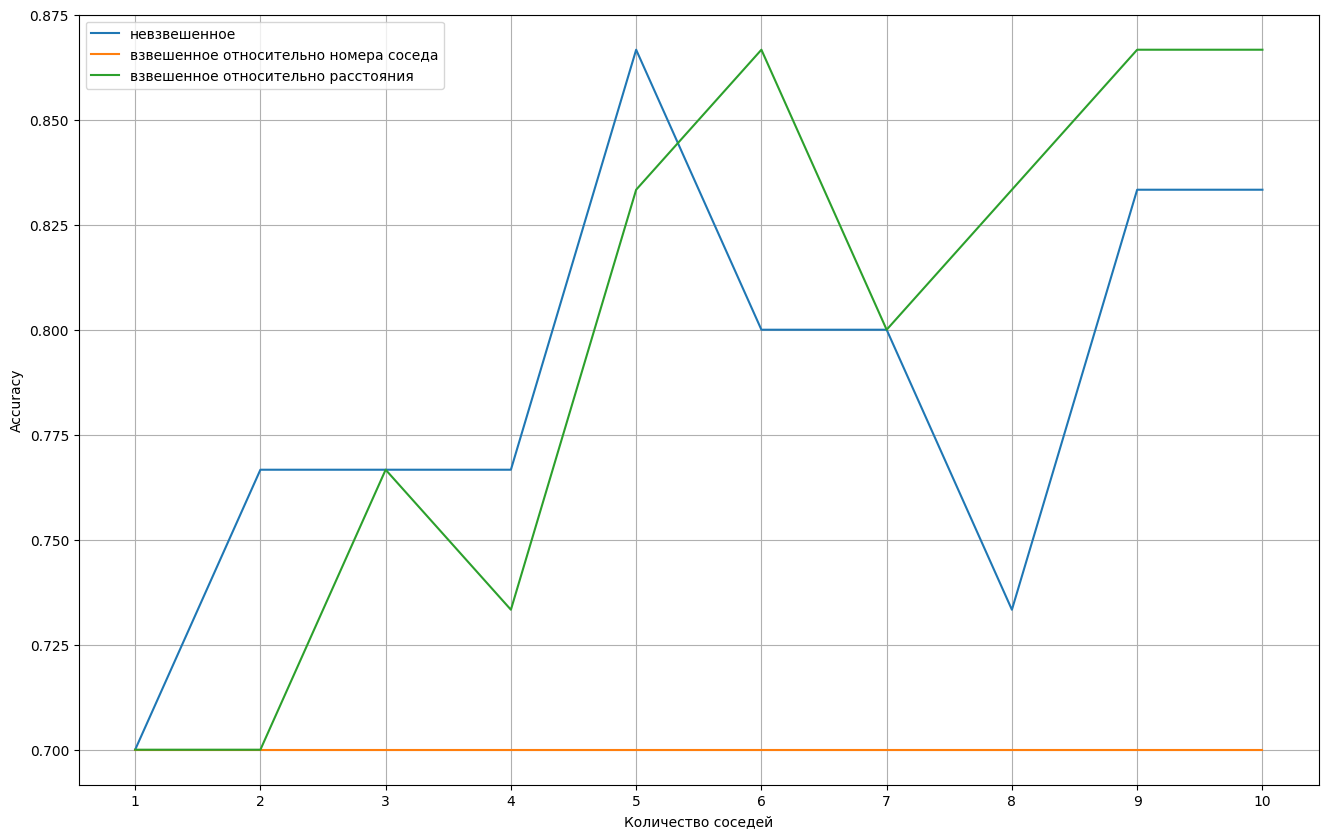

In [69]:
plt.figure(figsize=(16,10))
for key,val in results.items():
    plt.plot(k_variants, results[key],  label=f'{weight_humanize(key)}')
plt.grid()
plt.xticks(k_variants)
plt.xlabel('Количество соседей')
plt.ylabel('Accuracy')
plt.legend()
plt.show


Любопытно, на метрику относительно номера соседа вообще не влияет количество соседей, во всяком случаее выбранная метрика ($w(i) = q^{i}$,   $q \in (0,1)$)

Для остальных, оптимальное количество соседей, 5 - для невзвешенного голосования и 6 - для взвешенного голосования относительно расстония